In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import time
from pyDOE import lhs         #Latin Hypercube Sampling

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.16.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
x = np.linspace(-np.pi,np.pi,100)

u = 0 #solution

for k in range(1,6):
    u += np.sin(2*k*x)/(2*k) 

# Solution Plot

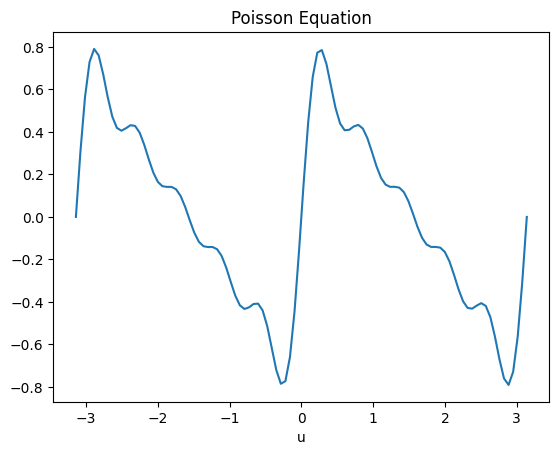

In [3]:
plt.plot(x,u)
plt.xlabel('x')
plt.xlabel('u')
plt.title('Poisson Equation')
plt.show()

# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [4]:
X_u_test = tf.reshape(x,[100,1])

# Domain bounds
lb = X_u_test[0]  # [-pi]
ub = X_u_test[-1] # [pi]

u = tf.reshape(u,(100,1))

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [5]:
def trainingdata(N_f):

    '''Boundary Conditions'''

    #Left egde (x = -π and u = 0)
    leftedge_x = -np.pi
    leftedge_u = 0
    
    #Right egde (x = -π and u = 0)
    rightedge_x = np.pi
    rightedge_u = 0

    X_u_train = np.vstack([leftedge_x, rightedge_x]) # X_u_train [2,1]
    u_train = np.vstack([leftedge_u, rightedge_u])   #corresponding u [2x1]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(1,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train 


# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self, x):
        x = (x - lb) / (ub - lb)  # Feature scaling
        
        a = x
        
        # Loop through all layers except the last one, applying tanh activation
        for i in range(len(self.W) // 2 - 1):  # Divide by 2 because self.W contains both weights and biases
            z = tf.add(tf.matmul(a, self.W[2 * i]), self.W[2 * i + 1])  # Linear transformation
            a = tf.nn.tanh(z)  # Apply tanh activation function
            
        # Last layer (output layer), no activation function
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1])  # No activation for the output layer (regression)
        return a

    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
    
        nu = 0.01/np.pi

        x_f = g[:,0:1]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)

            z = self.evaluate(x_f)
            u_x = tape.gradient(z,x_f)

        u_xx = tape.gradient(u_x, x_f)

        del tape
        
        source = 0
        
        for k in range(1,6):
            source += (2*k) * np.sin(2*k*x_f) 
            
        f = u_xx + source

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)       
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)      
        
        tf.print(loss_value, loss_u, loss_f, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

109.99701880773951 0.00046236895816932134 109.99655643878134 0.9965809240176746
Training time: 1.91
Test Error: 0.99658


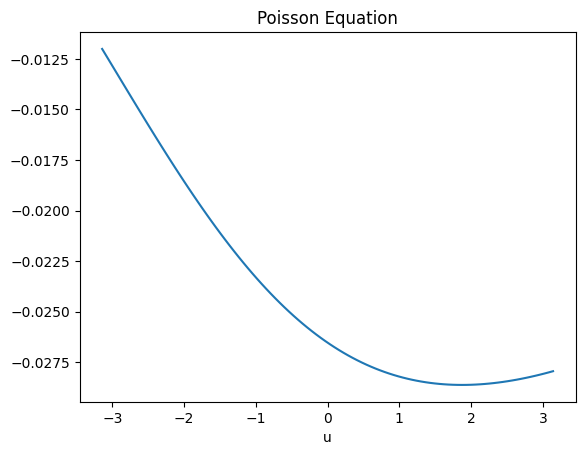

In [16]:
N_f = 100000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_f)

layers = np.array([1,20,20,20,20,20,20,50,1]) #2 hidden layers

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': 1,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

# print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

''' Solution Plot '''
fig,ax = plt.subplots()
plt.plot(X_u_test,u_pred)
plt.xlabel('x')
plt.xlabel('u')
plt.title('Poisson Equation')

plt.show()